In [8]:

import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image

%matplotlib inline

<video width="400" height="200" src="nb_images/road_video_compressed2.mp4" type="video/mp4" controls>

<img src="nb_images/box_label.png" style="width:500px;height:250;">


#### Inputs and outputs
- The **input** is a batch of images, and each image has the shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

#### Anchor Boxes
* Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that represent the different classes.  For this assignment, 5 anchor boxes were chosen for you (to cover the 80 classes), and stored in the file './model_data/yolo_anchors.txt'
* The dimension for anchor boxes is the second to last dimension in the encoding: $(m, n_H,n_W,anchors,classes)$.
* The YOLO architecture is: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).  


#### Encoding
Let's look in greater detail at what this encoding represents. 

<img src="nb_images/architecture.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: Encoding architecture for YOLO<br> </center></caption>



<img src="nb_images/flatten.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 3 </u></b>: Flattening the last two last dimensions<br> </center></caption>

<img src="nb_images/probability_extraction.png" style="width:700px;height:400;">
<caption><center> <u><b>Figure 4</u></b>: Find the class detected by each box<br> </center></caption>

* In figure 4, let's say for box 1 (cell 1), the probability that an object exists is $p_{1}=0.60$.  So there's a 60% chance that an object exists in box 1 (cell 1).  
* The probability that the object is the class "category 3 (a car)" is $c_{3}=0.73$.  
* The score for box 1 and for category "3" is $score_{1,3}=0.60 \times 0.73 = 0.44$.  
* Let's say you calculate the score for all 80 classes in box 1, and find that the score for the car class (class 3) is the maximum.  So you'll assign the score 0.44 and class "3" to this box "1".

<img src="nb_images/proba_map.png" style="width:300px;height:300;">

<img src="nb_images/anchor_map.png" style="width:200px;height:200;">


#### Non-Max suppression
In the figure above, the only boxes plotted are ones for which the model had assigned a high probability, but this is still too many boxes. You'd like to reduce the algorithm's output to a much smaller number of detected objects.  

To do so, you'll use **non-max suppression**. Specifically, you'll carry out these steps: 
- Get rid of boxes with a low score. Meaning, the box is not very confident about detecting a class, either due to the low probability of any object, or low probability of this particular class.
- Select only one box when several boxes overlap with each other and detect the same object.

<a name='2-2'></a>
### 2.2 - Filtering with a Threshold on Class Scores

You're going to first apply a filter by thresholding, meaning you'll get rid of any box for which the class "score" is less than a chosen threshold. 

The model gives you a total of 19x19x5x85 numbers, with each box described by 85 numbers. It's convenient to rearrange the (19,19,5,85) (or (19,19,425)) dimensional tensor into the following variables:  
- `box_confidence`: tensor of shape $(19, 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19, 19, 5, 4)$ containing the midpoint and dimensions $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes in each cell.
- `box_class_probs`: tensor of shape $(19, 19, 5, 80)$ containing the "class probabilities" $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.

<a name='ex-1'></a>
### Exercise 1 - yolo_filter_boxes

Implement `yolo_filter_boxes()`.
1. Compute box scores by doing the elementwise product as described in Figure 4 ($p \times c$).  
The following code may help you choose the right operator: 
```python
a = np.random.randn(19, 19, 5, 1)
b = np.random.randn(19, 19, 5, 80)
c = a * b # shape of c will be (19, 19, 5, 80)
```
This is an example of **broadcasting** (multiplying vectors of different sizes).

2. For each box, find:
    - the index of the class with the maximum box score
    - the corresponding box score
    
    **Useful References**
        * [tf.math.argmax](https://www.tensorflow.org/api_docs/python/tf/math/argmax)
        * [tf.math.reduce_max](https://www.tensorflow.org/api_docs/python/tf/math/reduce_max)

    **Helpful Hints**
        * For the `axis` parameter of `argmax` and `reduce_max`, if you want to select the **last** axis, one way to do so is to set `axis=-1`.  This is similar to Python array indexing, where you can select the last position of an array using `arrayname[-1]`.
        * Applying `reduce_max` normally collapses the axis for which the maximum is applied.  `keepdims=False` is the default option, and allows that dimension to be removed.  You don't need to keep the last dimension after applying the maximum here.


3. Create a mask by using a threshold. As a reminder: `([0.9, 0.3, 0.4, 0.5, 0.1] < 0.4)` returns: `[False, True, False, False, True]`. The mask should be `True` for the boxes you want to keep. 

4. Use TensorFlow to apply the mask to `box_class_scores`, `boxes` and `box_classes` to filter out the boxes you don't want. You should be left with just the subset of boxes you want to keep.   


In [2]:
def yolo_filter_boxes(boxes,box_confidence,box_class_probs,threshold=.6):
    
    box_scores = box_class_probs*box_confidence
    
    box_classes = tf.math.argmax(box_scores,axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores,axis=-1)
    
    filtering_mask = (box_class_scores >= threshold)
    
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
    
    return scores,boxes,classes
    
    

<img src="nb_images/non-max-suppression.png" style="width:500px;height:400;">
<caption><center> <u> <b>Figure 7</b> </u>: In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probability) of the 3 boxes. <br> </center></caption>


Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.
<img src="nb_images/iou.png" style="width:500px;height:400;">
<caption><center> <u> <b>Figure 8</b> </u>: Definition of "Intersection over Union". <br> </center></caption>

<a name='ex-2'></a>
### Exercise 2 - iou

Implement `iou()` 

Some hints:
- This code uses the convention that (0,0) is the top-left corner of an image, (1,0) is the upper-right corner, and (1,1) is the lower-right corner. In other words, the (0,0) origin starts at the top left corner of the image. As x increases, you move to the right.  As y increases, you move down.
- For this exercise, a box is defined using its two corners: upper left $(x_1, y_1)$ and lower right $(x_2,y_2)$, instead of using the midpoint, height and width. This makes it a bit easier to calculate the intersection.
- To calculate the area of a rectangle, multiply its height $(y_2 - y_1)$ by its width $(x_2 - x_1)$. Since $(x_1,y_1)$ is the top left and $x_2,y_2$ are the bottom right, these differences should be non-negative.
- To find the **intersection** of the two boxes $(xi_{1}, yi_{1}, xi_{2}, yi_{2})$: 
    - Feel free to draw some examples on paper to clarify this conceptually.
    - The top left corner of the intersection $(xi_{1}, yi_{1})$ is found by comparing the top left corners $(x_1, y_1)$ of the two boxes and finding a vertex that has an x-coordinate that is closer to the right, and y-coordinate that is closer to the bottom.
    - The bottom right corner of the intersection $(xi_{2}, yi_{2})$ is found by comparing the bottom right corners $(x_2,y_2)$ of the two boxes and finding a vertex whose x-coordinate is closer to the left, and the y-coordinate that is closer to the top.
    - The two boxes **may have no intersection**.  You can detect this if the intersection coordinates you calculate end up being the top right and/or bottom left corners of an intersection box.  Another way to think of this is if you calculate the height $(y_2 - y_1)$ or width $(x_2 - x_1)$ and find that at least one of these lengths is negative, then there is no intersection (intersection area is zero).  
    - The two boxes may intersect at the **edges or vertices**, in which case the intersection area is still zero.  This happens when either the height or width (or both) of the calculated intersection is zero.



In [3]:
def iou(box1,box2):
    
    (box1_x1,box1_y1,box1_x2,box1_y2)=box1
    (box2_x1,box2_y1,box2_x2,box2_y2)=box2
    
    
    xi1 = max(box1_x1,box2_x1)
    yi1 = max(box1_y1,box2_y1)
    xi2 = min(box1_x2,box2_x2)
    yi2 = min(box1_y2,box2_y2)
    inter_width = max((xi2 - xi1),0)
    inter_height=max((yi2 - yi1),0)
    inter_area = inter_width * inter_height
    
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    
    box1_area = (box1_x2-box1_x1)*((box1_y2-box1_y1))
    box2_area = (box2_x2-box2_x1)*((box2_y2-box2_y1))
    union_area = box1_area +box2_area - inter_area
    
    
    #IOU
    iou=inter_area/union_area
    
    return iou
    
    
    
    

 YOLO Non-max Suppression

You are now ready to implement non-max suppression. The key steps are: 
1. Select the box that has the highest score.
2. Compute the overlap of this box with all other boxes, and remove boxes that overlap significantly (iou >= `iou_threshold`).
3. Go back to step 1 and iterate until there are no more boxes with a lower score than the currently selected box.

This will remove all boxes that have a large overlap with the selected boxes. Only the "best" boxes remain.

<a name='ex-3'></a>
 - yolo_non_max_suppression

Implement `yolo_non_max_suppression()` using TensorFlow. TensorFlow has two built-in functions that are used to implement non-max suppression (so you don't actually need to use your `iou()` implementation):

**Reference documentation**: 

- [tf.image.non_max_suppression()](https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression)
```
tf.image.non_max_suppression(
    boxes,
    scores,
    max_output_size,
    iou_threshold=0.5,
    name=None
)
```
Note that in the version of TensorFlow used here, there is no parameter `score_threshold` (it's shown in the documentation for the latest version) so trying to set this value will result in an error message: *got an unexpected keyword argument `score_threshold`.*

- [tf.gather()](https://www.tensorflow.org/api_docs/python/tf/gather)
```
keras.gather(
    reference,
    indices
)
```

In [4]:
def yolo_non_max_suppression(scores,boxes,classes,max_boxes=10,iou_threshold=0.5):
    
    max_boxes_tensor = tf.Variable(max_boxes,dtype='int32')
    
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes_tensor,iou_threshold)
    
    scores = tf.gather(scores,nms_indices)
    boxes=tf.gather(boxes,nms_indices)
    classes = tf.gather(classes,nms_indices)
    
    return scores,boxes,classes

### - Wrapping Up the Filtering

It's time to implement a function taking the output of the deep CNN (the 19x19x5x85 dimensional encoding) and filtering through all the boxes using the functions you've just implemented. 

<a name='ex-4'></a>
### - yolo_eval

Implement `yolo_eval()` which takes the output of the YOLO encoding and filters the boxes using score threshold and NMS. There's just one last implementational detail you have to know. There're a few ways of representing boxes, such as via their corners or via their midpoint and height/width. YOLO converts between a few such formats at different times, using the following functions (which are provided): 

```python
boxes = yolo_boxes_to_corners(box_xy, box_wh) 
```
which converts the yolo box coordinates (x,y,w,h) to box corners' coordinates (x1, y1, x2, y2) to fit the input of `yolo_filter_boxes`
```python
boxes = scale_boxes(boxes, image_shape)
```
YOLO's network was trained to run on 608x608 images. If you are testing this data on a different size image -- for example, the car detection dataset had 720x1280 images -- this step rescales the boxes so that they can be plotted on top of the original 720x1280 image.  


In [9]:
def yolo_boxes_to_corners(box_xy, box_wh):
   
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

In [28]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    

    """
    
    ### START CODE HERE
    # Retrieve outputs of the YOLO model (≈1 line)
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    
    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy,box_wh)
    
    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(boxes,box_confidence,box_class_probs,score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes,image_shape)
    
    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes,classes,max_boxes,iou_threshold)
    ### END CODE HERE
    
    return scores, boxes, classes

In [29]:
tf.random.set_seed(10)
yolo_outputs = (tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
scores, boxes, classes = yolo_eval(yolo_outputs)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

assert type(scores) == EagerTensor, "Use tensoflow functions"
assert type(boxes) == EagerTensor, "Use tensoflow functions"
assert type(classes) == EagerTensor, "Use tensoflow functions"

assert scores.shape == (10,), "Wrong shape"
assert boxes.shape == (10, 4), "Wrong shape"
assert classes.shape == (10,), "Wrong shape"
    
assert np.isclose(scores[2].numpy(), 171.60194), "Wrong value on scores"
assert np.allclose(boxes[2].numpy(), [-1240.3483, -3212.5881, -645.78, 2024.3052]), "Wrong value on boxes"
assert np.isclose(classes[2].numpy(), 16), "Wrong value on classes"
    
print("\033[92m All tests passed!")
# END UNIT TEST

scores[2] = 171.60194
boxes[2] = [-1240.3483 -3212.5881  -645.78    2024.3052]
classes[2] = 16
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)
 All tests passed!


In [30]:
class_names=read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size=(608,608)

In [31]:
yolo_model = load_model("model_data/",compile=False)

In [32]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 608, 608, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 608, 608, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [33]:
def predict(image_file):
    image,image_data=preprocess_image("images/"+image_file,model_image_size=(608,608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs,anchors,len(class_names))
    
    out_scores,out_boxes,out_classes = yolo_eval(yolo_outputs,[image.size[1],image.size[0]],10,0.3,0.5)
    
    print("Found {} boxes for {}".format(len(out_boxes),"images/"+image_file))
    colors=get_colors_for_classes(len(class_names))
    draw_boxes(image,out_boxes,out_classes,class_names,out_scores)
    image.save(os.path.join("out",image_file),quality=100)
    
    output_image = Image.open(os.path.join("out",image_file))
    imshow(output_image)
    return out_scores,out_boxes,out_classes

Found 2 boxes for images/giraffe.jpg
giraffe 0.89 (166, 0) (439, 448)
zebra 0.83 (241, 208) (422, 442)


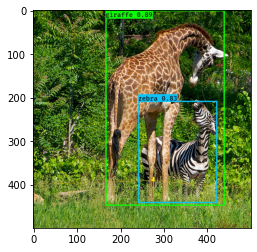

In [36]:
out_scores, out_boxes, out_classes = predict("giraffe.jpg")

<center>
<video width="400" height="200" src="nb_images/pred_video_compressed2.mp4" type="video/mp4" controls>
</video>
</center>

Summary for YOLO

- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output. 
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers. 
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture. 
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and 80 is the number of classes we'd like to detect
- You then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output. 